In [1]:
import csv
import math
import random
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

# -------------------- Load CSV -------------------- #
def load_mnist_csv(path):
    X, y = [], []
    with open(path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            label = int(row[0])
            pixels = [int(p) / 255.0 for p in row[1:]]
            X.append(pixels)
            y.append(label)
    return X, y

# -------------------- One-Hot Encoding -------------------- #
def one_hot_encode(labels, num_classes=10):
    return [[1 if i == label else 0 for i in range(num_classes)] for label in labels]

# -------------------- Activation Functions -------------------- #
def relu(x): return [max(0, val) for val in x]
def relu_derivative(x): return [1 if val > 0 else 0 for val in x]
def softmax(x):
    max_x = max(x)
    exps = [math.exp(i - max_x) for i in x]
    total = sum(exps)
    return [j / total for j in exps]

# -------------------- Loss Function -------------------- #
def cross_entropy(predicted, actual):
    return -sum(a * math.log(p + 1e-15) for p, a in zip(predicted, actual))

# -------------------- Init Weights -------------------- #
def init_weights(in_size, out_size):
    return [[random.uniform(-0.1, 0.1) for _ in range(in_size)] for _ in range(out_size)]
def init_bias(size): return [0.0 for _ in range(size)]

# -------------------- Forward Pass -------------------- #
def forward(x, W1, b1, W2, b2):
    z1 = [sum(w * xi for w, xi in zip(row, x)) + b for row, b in zip(W1, b1)]
    a1 = relu(z1)
    z2 = [sum(w * ai for w, ai in zip(row, a1)) + b for row, b in zip(W2, b2)]
    a2 = softmax(z2)
    return z1, a1, z2, a2

# -------------------- Backpropagation -------------------- #
def backward(x, y, z1, a1, z2, a2, W2):
    dz2 = [a2_i - y_i for a2_i, y_i in zip(a2, y)]
    dW2 = [[dz2_i * a1_j for a1_j in a1] for dz2_i in dz2]
    db2 = dz2[:]

    da1 = [sum(dz2[k] * W2[k][j] for k in range(len(W2))) for j in range(len(W2[0]))]
    dz1 = [da1_i * relu_derivative([z1[i]])[0] for i, da1_i in enumerate(da1)]
    dW1 = [[dz1_i * x_j for x_j in x] for dz1_i in dz1]
    db1 = dz1[:]

    return dW1, db1, dW2, db2

# -------------------- Update Functions -------------------- #
def update(weights, grads, lr):
    for i in range(len(weights)):
        for j in range(len(weights[0])):
            weights[i][j] -= lr * grads[i][j]

def update_biases(biases, grads, lr):
    for i in range(len(biases)):
        biases[i] -= lr * grads[i]

# -------------------- Training Loop -------------------- #
def train_model(train_X, train_y, epochs=5, batch_size=32, lr=0.05):
    input_size = len(train_X[0])
    hidden_size = 128
    output_size = 10

    W1 = init_weights(input_size, hidden_size)
    b1 = init_bias(hidden_size)
    W2 = init_weights(hidden_size, output_size)
    b2 = init_bias(output_size)

    loss_list = []
    acc_list = []

    for epoch in range(1, epochs + 1):
        combined = list(zip(train_X, train_y))
        random.shuffle(combined)
        train_X[:], train_y[:] = zip(*combined)

        total_loss = 0
        correct = 0

        for i in range(0, len(train_X), batch_size):
            batch_X = train_X[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]
            batch_y_oh = one_hot_encode(batch_y)

            dW1_total = [[0]*input_size for _ in range(hidden_size)]
            db1_total = [0]*hidden_size
            dW2_total = [[0]*hidden_size for _ in range(output_size)]
            db2_total = [0]*output_size

            for x, y_true, y_oh in zip(batch_X, batch_y, batch_y_oh):
                z1, a1, z2, a2 = forward(x, W1, b1, W2, b2)
                loss = cross_entropy(a2, y_oh)
                total_loss += loss
                if a2.index(max(a2)) == y_true:
                    correct += 1
                dW1, db1, dW2, db2 = backward(x, y_oh, z1, a1, z2, a2, W2)

                for j in range(hidden_size):
                    for k in range(input_size):
                        dW1_total[j][k] += dW1[j][k]
                for j in range(hidden_size):
                    db1_total[j] += db1[j]
                for j in range(output_size):
                    for k in range(hidden_size):
                        dW2_total[j][k] += dW2[j][k]
                for j in range(output_size):
                    db2_total[j] += db2[j]

            batch_len = len(batch_X)
            update(W1, [[val / batch_len for val in row] for row in dW1_total], lr)
            update_biases(b1, [val / batch_len for val in db1_total], lr)
            update(W2, [[val / batch_len for val in row] for row in dW2_total], lr)
            update_biases(b2, [val / batch_len for val in db2_total], lr)

        avg_loss = total_loss / len(train_X)
        accuracy = correct / len(train_X)
        print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f} — Accuracy: {accuracy:.4f}")
        loss_list.append(avg_loss)
        acc_list.append(accuracy)

    return W1, b1, W2, b2, loss_list, acc_list

In [2]:
train_X, train_y = load_mnist_csv("mnist_train.csv")
W1, b1, W2, b2, loss_list, acc_list = train_model(train_X, train_y, epochs=5)

Epoch 1/5 — Loss: 0.4188 — Accuracy: 0.8857
Epoch 2/5 — Loss: 0.2159 — Accuracy: 0.9393
Epoch 3/5 — Loss: 0.1641 — Accuracy: 0.9540
Epoch 4/5 — Loss: 0.1331 — Accuracy: 0.9621
Epoch 5/5 — Loss: 0.1124 — Accuracy: 0.9681


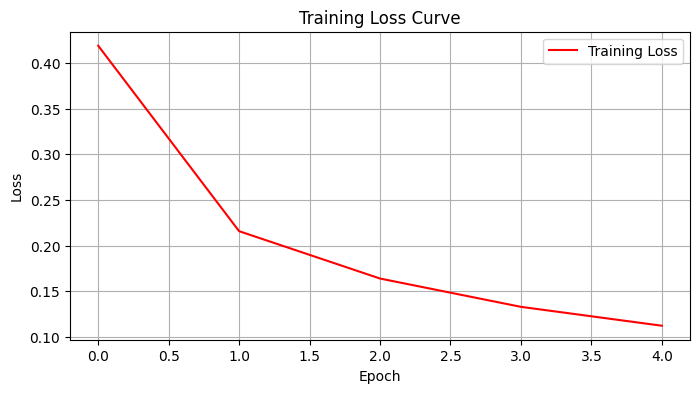

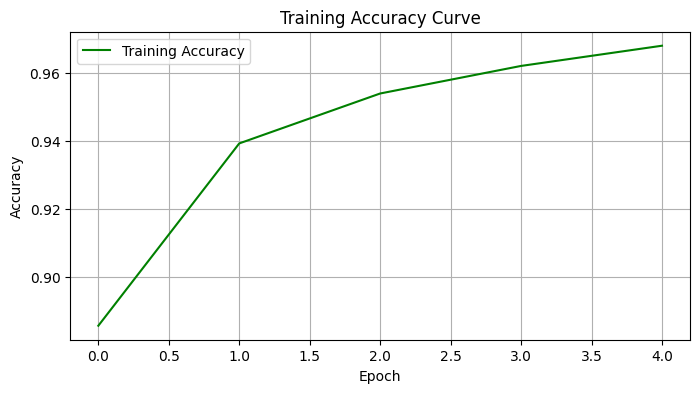

In [3]:
# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_list, label='Training Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(8, 4))
plt.plot(acc_list, label='Training Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Save model to file
model = {
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
}

with open('mnist_scratch_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved as mnist_scratch_model.pkl")

✅ Model saved as mnist_scratch_model.pkl
